In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import yfinance as yf 
import pandas_datareader as pdr
from simulation.simulation import simulate_normal_returns, alpha_stable_sampler_QMC

%load_ext autoreload
%autoreload 2

In [ ]:
# TO DO : i) entrainer le LSTM ii) calculer les poids optimaux et ploter

## 1) Loading market data 

In [20]:
tickers_cac40 = [
    "ACC.PA",  # Accor
    "AI.PA",   # Air Liquide
    "AIR.PA",  # Airbus Group
    "MT.AS",   # ArcelorMittal
    "CS.PA",   # AXA
    "BNP.PA",  # BNP Paribas
    "EN.PA",   # Bouygues
    "CAP.PA",  # Capgemini
    "CA.PA",   # Carrefour
    "ACA.PA",  # Crédit Agricole
    "BN.PA",   # Danone
    "DSY.PA",  # Dassault Systèmes
    "EDEN.PA", # Edenred
    "ENGI.PA", # Engie
    "EL.PA",   # EssilorLuxottica
    "ERF.PA",  # Eurofins Scientific
    "RMS.PA",  # Hermès International
    "KER.PA",  # Kering
    "LR.PA",   # Legrand
    "OR.PA",   # L'Oréal
    "MC.PA",   # LVMH
    "ML.PA",   # Michelin
    "ORA.PA",  # Orange
    "RI.PA",   # Pernod Ricard
    "PUB.PA",  # Publicis Groupe
    "RNO.PA",  # Renault
    "SAF.PA",  # Safran
    "SGO.PA",  # Saint-Gobain
    "SAN.PA",  # Sanofi
    "SU.PA",   # Schneider Electric
    "GLE.PA",  # Société Générale
    "STLA.PA", # Stellantis
    "STM.PA",  # STMicroelectronics
    "TEP.PA",  # Téléperformance
    "HO.PA",   # Thales
    "TTE.PA",  # TotalEnergies
    "URW.PA",  # Unibail-Rodamco-Westfield
    "VIE.PA",  # Veolia Environnement
    "DG.PA",   # Vinci
    "VIV.PA"   # Vivendi
]

tickers_cac40_dict = {
    "ACC.PA": "Accor",
    "AI.PA": "Air Liquide",
    "AIR.PA": "Airbus Group",
    "MT.AS": "ArcelorMittal",
    "CS.PA": "AXA",
    "BNP.PA": "BNP Paribas",
    "EN.PA": "Bouygues",
    "CAP.PA": "Capgemini",
    "CA.PA": "Carrefour",
    "ACA.PA": "Crédit Agricole",
    "BN.PA": "Danone",
    "DSY.PA": "Dassault Systèmes",
    "EDEN.PA": "Edenred",
    "ENGI.PA": "Engie",
    "EL.PA": "EssilorLuxottica",
    "ERF.PA": "Eurofins Scientific",
    "RMS.PA": "Hermès International",
    "KER.PA": "Kering",
    "LR.PA": "Legrand",
    "OR.PA": "L'Oréal",
    "MC.PA": "LVMH",
    "ML.PA": "Michelin",
    "ORA.PA": "Orange",
    "RI.PA": "Pernod Ricard",
    "PUB.PA": "Publicis Groupe",
    "RNO.PA": "Renault",
    "SAF.PA": "Safran",
    "SGO.PA": "Saint-Gobain",
    "SAN.PA": "Sanofi",
    "SU.PA": "Schneider Electric",
    "GLE.PA": "Société Générale",
    "STLA.PA": "Stellantis",
    "STM.PA": "STMicroelectronics",
    "TEP.PA": "Téléperformance",
    "HO.PA": "Thales",
    "TTE.PA": "TotalEnergies",
    "URW.PA": "Unibail-Rodamco-Westfield",
    "VIE.PA": "Veolia Environnement",
    "DG.PA": "Vinci",
    "VIV.PA": "Vivendi"
}

In [21]:
selected_tickers = [tickers_cac40[i] for i in [1,4,6,8,18]]
selected_tickers_names = [tickers_cac40_dict[key] for key in selected_tickers]
start_date = '2010-01-01'
interval = '1d'

market_data = yf.download(selected_tickers, start='2010-01-01', interval=interval).reset_index()
market_data["Date"] = market_data["Date"].dt.strftime('%Y/%m')
market_data = market_data[["Date", "Adj Close"]]
print(market_data.shape)
market_data.head()

[*********************100%***********************]  5 of 5 completed

(3821, 6)


Price      Date  Adj Close                                           
Ticker               AI.PA      CA.PA     CS.PA      EN.PA      LR.PA
0       2010/01  30.840050  21.601980  7.704947  16.893999  14.546642
1       2010/01  30.223249  22.113436  7.833363  17.101633  14.600061
2       2010/01  30.037117  21.951424  7.913622  17.192905  14.503913
3       2010/01  30.000624  21.703640  7.824191  16.957888  14.560888
4       2010/01  30.095516  21.916477  7.849414  16.964731  14.728255

## 2) Retrieving useful statistics

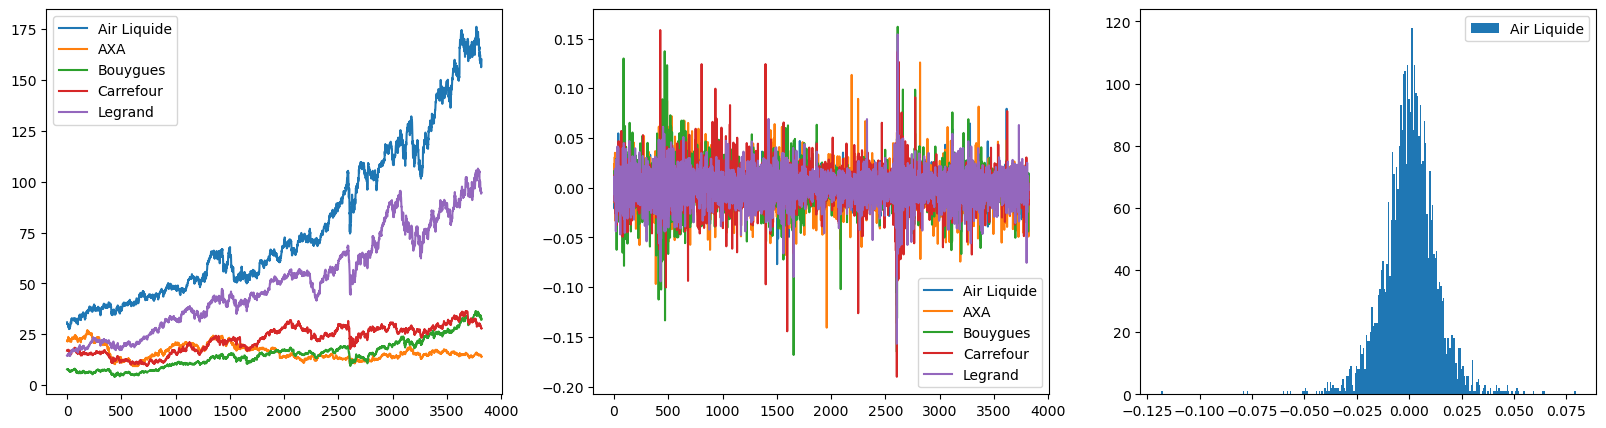

In [32]:
market_returns = np.log(market_data['Adj Close']) - np.log(market_data['Adj Close'].shift(1))
market_returns.dropna(inplace=True)
mean_returns = market_returns.mean()
mean_returns_value = mean_returns.values
cov_market = market_returns.cov() 
cov_market_values = cov_market.values

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(market_data['Adj Close'], label=selected_tickers_names)
plt.legend()
plt.subplot(132)
plt.plot(market_returns, label=selected_tickers_names)
plt.legend()
plt.subplot(133)
i = 0 
plt.hist(market_returns.iloc[:,i], label=selected_tickers_names[i], bins=300)
plt.legend()
plt.show()

### 3) Simulating returns

In [49]:
np.random.seed(42)

In [ ]:
# N correspond au nombre de timesteps (on est dans l'unité de la data originale, donc jour en l'occurence cf variable "interval" plus haut)
# La 2e dimension du tenseur donne les différentes simulations 
# la 3e au nombre d'assets

simulated_returns = simulate_normal_returns(mu=mean_returns_value, cov=cov_market_values, N=4000, n_simul=40)
simulated_returns.shape

(4000, 40, 5)

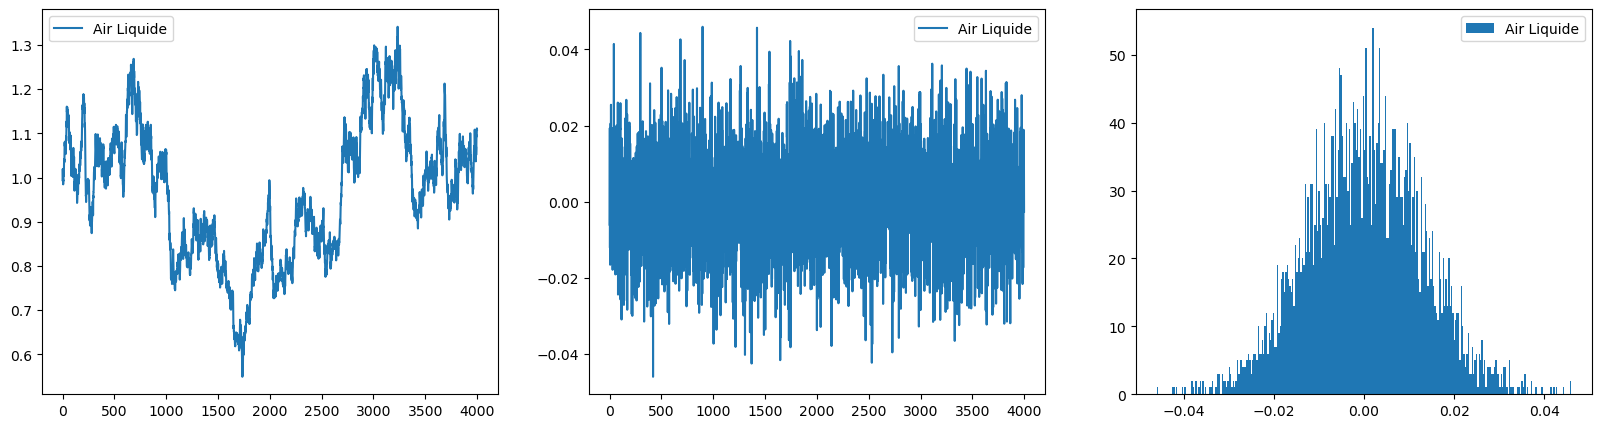

In [59]:
i = 0 
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(np.cumprod(1 + simulated_returns[:, i, 0]), label=selected_tickers_names[i])
plt.legend()
plt.subplot(132)
plt.plot(simulated_returns[:, i, 0], label=selected_tickers_names[i])
plt.legend()
plt.subplot(133)
i = 0 
plt.hist(simulated_returns[:, i, 0], label=selected_tickers_names[i], bins=300)
plt.legend()
plt.show()